Found 4103 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/10
129/129 [==============================] - 705s 5s/step - loss: 0.2854 - precisao: 0.9034 - sensibilidade: 0.9283 - f1: 0.9138 - val_loss: 0.3859 - val_precisao: 0.7936 - val_sensibilidade: 0.9674 - val_f1: 0.8712
Epoch 2/10
129/129 [==============================] - 690s 5s/step - loss: 0.1793 - precisao: 0.9507 - sensibilidade: 0.9591 - f1: 0.9538 - val_loss: 0.3096 - val_precisao: 0.8135 - val_sensibilidade: 0.9722 - val_f1: 0.8836
Epoch 3/10
129/129 [==============================] - 681s 5s/step - loss: 0.1460 - precisao: 0.9644 - sensibilidade: 0.9655 - f1: 0.9639 - val_loss: 0.1610 - val_precisao: 0.8917 - val_sensibilidade: 0.9721 - val_f1: 0.9281
Epoch 4/10
129/129 [==============================] - 688s 5s/step - loss: 0.1311 - precisao: 0.9639 - sensibilidade: 0.9721 - f1: 0.9669 - val_loss: 0.2523 - val_precisao: 0.8639 - val_sensibilidade: 1.0000 - val_f1: 0.9255
Epoch 5/10
129/12

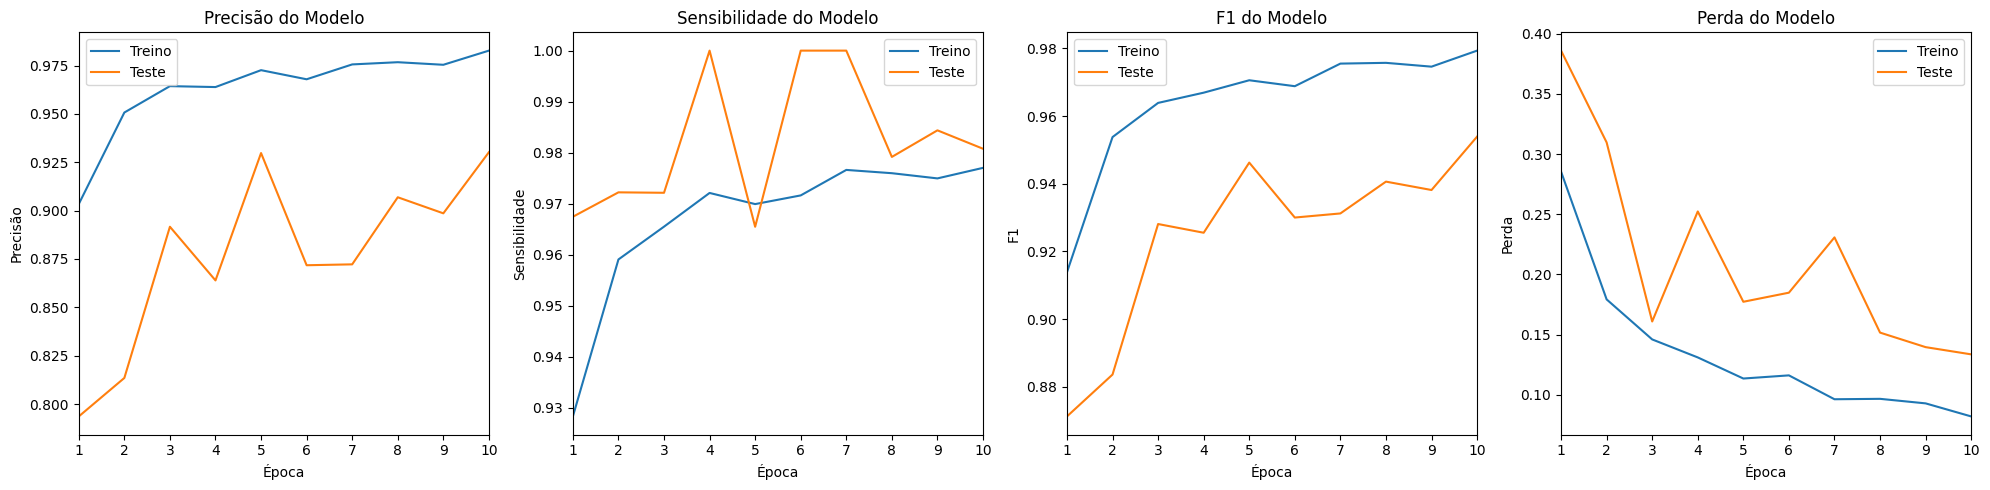

Found 624 images belonging to 2 classes.
20/20 [==============================] - 100s 5s/step - loss: 0.1778 - precisao: 0.9604 - sensibilidade: 0.9425 - f1: 0.9499
Perda no Teste: 0.1777907907962799
Precisão no Teste: 0.9603523015975952
Sensibilidade no Teste: 0.9424770474433899
F1 no Teste: 0.9499490857124329


In [9]:
# -----------------------
# Instalação dos pacotes necessários:
# Se estiver rodando este código pela primeira vez em um ambiente novo,
# execute as linhas abaixo para instalar os pacotes necessários.
# -----------------------

# Importa as bibliotecas e módulos necessários
import keras
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import Model, layers 
import keras.backend as K
import numpy as np  # Certifique-se de importar numpy
import matplotlib.pyplot as plt

# Define a porcentagem de imagens usadas para validação
porcentagem_validacao = 0.20

# -----------------------
# Definição de Métricas
# -----------------------
# Funções para calcular as métricas: sensibilidade, precisão e F1
def sensibilidade(y_verdadeiro, y_predito):
    verdadeiros_positivos = K.sum(K.round(K.clip(y_verdadeiro * y_predito, 0, 1)))
    positivos_possiveis = K.sum(K.round(K.clip(y_verdadeiro, 0, 1)))
    sensibilidade = verdadeiros_positivos / (positivos_possiveis + K.epsilon())
    return sensibilidade

def precisao(y_verdadeiro, y_predito):
    verdadeiros_positivos = K.sum(K.round(K.clip(y_verdadeiro * y_predito, 0, 1)))
    positivos_preditos = K.sum(K.round(K.clip(y_predito, 0, 1)))
    precisao = verdadeiros_positivos / (positivos_preditos + K.epsilon())
    return precisao

def f1(y_verdadeiro, y_predito):
    prec = precisao(y_verdadeiro, y_predito)
    sens = sensibilidade(y_verdadeiro, y_predito)
    return 2 * ((prec * sens) / (prec + sens + K.epsilon()))

# -----------------------
# Preparação de Dados
# -----------------------
# Adiciona Data Augmentation ao gerador de treinamento
# Data Augmentation ajuda a ampliar o conjunto de dados, criando variações das imagens
gerador_data = ImageDataGenerator(
    validation_split=porcentagem_validacao,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Cria geradores de imagens para treinamento e validação
gerador_treinamento = gerador_data.flow_from_directory(
    "C:/Users/Beatriz/Desktop/Otimizado/chest_xray/train",
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    target_size=(224,224),
    subset="training"
)

gerador_validacao = gerador_data.flow_from_directory(
    "C:/Users/Beatriz/Desktop/Otimizado/chest_xray/val",
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    target_size=(224,224)
)

# -----------------------
# Definição e Compilação do Modelo
# -----------------------
# Carrega o modelo pré-treinado ResNet50 do Imagenet atravez da biblioteca KERAS 
# sem as camadas densas
base_convolucional = ResNet50(include_top=False)


# Configura as últimas 5 camadas para treinamento
for camada in base_convolucional.layers[:-5]:
    camada.trainable = False

# Define a arquitetura do modelo
x = base_convolucional.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predicoes = layers.Dense(1, activation='sigmoid')(x)
modelo = Model(base_convolucional.input, predicoes)



#ajusta os parâmetros da rede neural para minimizar o erro (a perda)
otimizador = keras.optimizers.Adam(learning_rate=0.0001)
# Compila o modelo
modelo.compile(loss='binary_crossentropy', 
               optimizer=otimizador, metrics=[precisao, sensibilidade, f1])



# -----------------------
# Treinamento
# -----------------------

# Define a quantidade de batches e épocas
qtd_batches_treino = len(gerador_treinamento)
qtd_batches_validacao = len(gerador_validacao)
qtd_epocas = 10

# Treina o modelo usando os geradores de treinamento e validação
historico = modelo.fit(
    gerador_treinamento, 
    epochs=qtd_epocas, 
    validation_data=gerador_validacao,
    steps_per_epoch=qtd_batches_treino, 
    validation_steps=qtd_batches_validacao
)


# -----------------------
# Avaliação e Visualização
# -----------------------
# Exibe a evolução das métricas e da função de perda durante o treinamento
# Exibindo dados de Precisão
epocas = range(0, qtd_epocas)
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.plot(historico.history['precisao'], label='Treino')
plt.plot(historico.history['val_precisao'], label='Valid.')
plt.title('Precisão do Modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend()
plt.xlim(0, 9)  # Define o limite do eixo X de 0 a 9
plt.xticks(np.arange(0, 10, 1), labels=np.arange(1, 11, 1))  # Define os ticks do eixo X de 1 a 10 com intervalo de 1

plt.subplot(1, 4, 2)
plt.plot(historico.history['sensibilidade'], label='Treino')
plt.plot(historico.history['val_sensibilidade'], label='Valid.')
plt.title('Sensibilidade do Modelo')
plt.ylabel('Sensibilidade')
plt.xlabel('Época')
plt.legend()
plt.xlim(0, 9)  # Define o limite do eixo X de 0 a 9
plt.xticks(np.arange(0, 10, 1), labels=np.arange(1, 11, 1))  # Define os ticks do eixo X de 1 a 10 com intervalo de 1

plt.subplot(1, 4, 3)
plt.plot(historico.history['f1'], label='Treino')
plt.plot(historico.history['val_f1'], label='Valid.')
plt.title('F1 do Modelo')
plt.ylabel('F1')
plt.xlabel('Época')
plt.legend()
plt.xlim(0, 9)  # Define o limite do eixo X de 0 a 9
plt.xticks(np.arange(0, 10, 1), labels=np.arange(1, 11, 1))  # Define os ticks do eixo X de 1 a 10 com intervalo de 1

plt.subplot(1, 4, 4)
plt.plot(historico.history['loss'], label='Treino')
plt.plot(historico.history['val_loss'], label='Valid.')
plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend()
plt.xlim(0, 9)  # Define o limite do eixo X de 0 a 9
plt.xticks(np.arange(0, 10, 1), labels=np.arange(1, 11, 1))  # Define os ticks do eixo X de 1 a 10 com intervalo de 1

plt.tight_layout()
plt.show()


# Avalia o modelo no conjunto de teste
gerador_teste = ImageDataGenerator()
conjunto_teste = gerador_teste.flow_from_directory(
    "C:/Users/Beatriz/Desktop/Otimizado/chest_xray/test",
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    target_size=(224,224)
)

# Obtém e exibe as métricas de avaliação para o conjunto de teste
perda, prec, sens, f1 = modelo.evaluate(conjunto_teste, steps=len(conjunto_teste))
print(f"Perda no Teste: {perda}")
print(f"Precisão no Teste: {prec}")
print(f"Sensibilidade no Teste: {sens}")
print(f"F1 no Teste: {f1}")
